In [1]:
import numpy as np
import tensorflow as tf
import sklearn
import matplotlib
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pathlib
import numpy as np
from tensorflow.keras.preprocessing import image
from skimage.io import imread
import cv2 as cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras import Input
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
def load_image_paths(container_path):
    image_dir = pathlib.Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    image_paths = []
    flat_data = []
    target = []
    count = 0
    train_img_path = []
    train_label = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            count += 1
            train_img_path.append(str(file))
            train_label.append(categories[i])

    X = np.array(train_img_path)
    y = np.array(train_label)
    catStringArr = np.array(categories)

    return X, y, catStringArr


In [4]:
X = []
y = []
X, y, labelStringArr = load_image_paths("/home/pascal_steiger/Downloads/data/")
img_df = pd.DataFrame(zip(X, y), columns=["path", "label"])

print(labelStringArr)

img_df.sample(n=10)

['MKD' 'HRV' 'ISL' 'IRL' 'ITA' 'HUN' 'LVA' 'GBR' 'FRA' 'LTU' 'AUT' 'SVN'
 'FIN' 'ESP' 'NOR' 'BGR' 'PRT' 'SVK' 'BEL' 'EST' 'POL' 'CZE' 'NLD' 'CHE'
 'DNK' 'SWE']


,path,label
5745,/home/pascal_steiger/Downloads/data/HUN/img_HU...,HUN
382,/home/pascal_steiger/Downloads/data/MKD/img_MK...,MKD
16529,/home/pascal_steiger/Downloads/data/BGR/img_BG...,BGR
22310,/home/pascal_steiger/Downloads/data/CZE/img_CZ...,CZE
23836,/home/pascal_steiger/Downloads/data/CHE/img_46...,CHE
8260,/home/pascal_steiger/Downloads/data/FRA/img_45...,FRA
4983,/home/pascal_steiger/Downloads/data/ITA/img_IT...,ITA
10473,/home/pascal_steiger/Downloads/data/AUT/img_AU...,AUT
6444,/home/pascal_steiger/Downloads/data/LVA/img_LV...,LVA
4041,/home/pascal_steiger/Downloads/data/ITA/img_IT...,ITA


In [5]:
train_df, test_df = train_test_split(img_df, shuffle=True, test_size=0.2, random_state=42)


print(train_df.sample(n=5))
print(train_df.shape)
print(test_df.sample(n=5))
print(test_df.shape)


                                                    path label
12122  /home/pascal_steiger/Downloads/data/FIN/img_FI...   FIN
21578  /home/pascal_steiger/Downloads/data/CZE/img_CZ...   CZE
16542  /home/pascal_steiger/Downloads/data/BGR/img_BG...   BGR
12639  /home/pascal_steiger/Downloads/data/FIN/img_FI...   FIN
18367  /home/pascal_steiger/Downloads/data/SVK/img_SV...   SVK
(21234, 2)
                                                    path label
7049   /home/pascal_steiger/Downloads/data/GBR/img_54...   GBR
1350   /home/pascal_steiger/Downloads/data/HRV/img_HR...   HRV
19319  /home/pascal_steiger/Downloads/data/BEL/img_50...   BEL
21007  /home/pascal_steiger/Downloads/data/POL/img_PO...   POL
2492   /home/pascal_steiger/Downloads/data/ISL/img_IS...   ISL
(5309, 2)


In [9]:
def changeChannel(inp):
    return inp[:, :, ::-1]

In [7]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

In [8]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="path",
        y_col="label",
        target_size=(224, 224),
        batch_size=32,
        class_mode="sparse",
        seed=42
)


validation_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="path",
        y_col="label",
        target_size=(224, 224),
        batch_size=32,
        class_mode="sparse",
        shuffle=False
)

Found 21234 validated image filenames belonging to 26 classes.
Found 5309 validated image filenames belonging to 26 classes.


In [9]:
with tf.device("/device:GPU:1"):
    from tensorflow.keras.applications.vgg19 import VGG19
    vgg = VGG19(include_top=True,weights="imagenet")
    tl_vgg19 = tf.keras.Model(vgg.input, vgg.layers[-4].output)
    
    for layer in tl_vgg19.layers:
        layer.trainable = False

    for layer in tl_vgg19.layers[-5:]:
        layer.trainable = True 
    print(tl_vgg19.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
I = Input(shape=(224, 224, 3))

x = tl_vgg19(I)



dense = Dense(1024, activation='relu', name='denserelu')(x)

dropout = Dropout(0.1)(dense)

dense2 = Dense(512, activation='relu', name='denserelu2')(dropout)

dropout2 = Dropout(0.1)(dense2)

dense3 = Dense(26, activation='softmax', name='my_dense')(dropout2)


new_model2 = tf.keras.Model(I, dense3)

new_model2.summary()





Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
model (Functional)           (None, 25088)             20024384  
_________________________________________________________________
denserelu (Dense)            (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
denserelu2 (Dense)           (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
my_dense (Dense)             (None, 26)                1333

In [11]:
def unwrap_model(model):
    mdl = model.get_layer('model')
    inp = mdl.input
    out = model.get_layer('denserelu')(mdl.output)
    out = model.get_layer('dropout')(out)
    out = model.get_layer('denserelu2')(out)
    out = model.get_layer('dropout_1')(out)
    out = model.get_layer('my_dense')(out)
    return tf.keras.Model(inp, out)   
    
new_model2 = unwrap_model(new_model2)

    
new_model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [12]:
# define callbacks for early stopping

early_stopping = EarlyStopping(
    monitor='val_sparse_categorical_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_sparse_categorical_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [13]:
with tf.device("/device:GPU:1"):
    new_model2.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

with tf.device("/device:GPU:1"):
    history = new_model2.fit(
          train_generator,
          epochs=200,
          verbose = 1,
          callbacks=callbacks,
          #steps_per_epoch=2000 // 32,
          validation_data=validation_generator)
    new_model2.save('CNN-TL_vgg19_v2.h5')

Epoch 1/200
664/664 [==============================] - 393s 575ms/step - loss: 4.1222 - sparse_categorical_accuracy: 0.0552 - val_loss: 3.2554 - val_sparse_categorical_accuracy: 0.0578
Epoch 2/200
664/664 [==============================] - 368s 554ms/step - loss: 6.2546 - sparse_categorical_accuracy: 0.0567 - val_loss: 3.2554 - val_sparse_categorical_accuracy: 0.0578
Epoch 3/200
664/664 [==============================] - 369s 555ms/step - loss: 3.2546 - sparse_categorical_accuracy: 0.0571 - val_loss: 3.2549 - val_sparse_categorical_accuracy: 0.0578
Epoch 4/200
664/664 [==============================] - 365s 549ms/step - loss: 3.2547 - sparse_categorical_accuracy: 0.0571 - val_loss: 3.2551 - val_sparse_categorical_accuracy: 0.0578
Epoch 5/200
664/664 [==============================] - 368s 554ms/step - loss: 3.2546 - sparse_categorical_accuracy: 0.0571 - val_loss: 3.2550 - val_sparse_categorical_accuracy: 0.0578
Epoch 6/200
664/664 [==============================] - 364s 548ms/step - lo

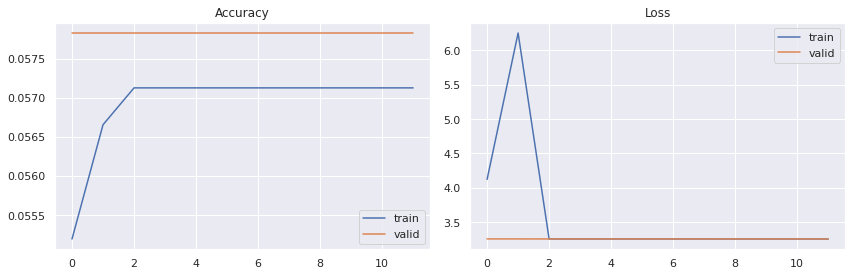

In [14]:
# plot training and validation metrics

sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['sparse_categorical_accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_sparse_categorical_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('CNN(224,224)-tl_vgg19_v2.png')

plt.show()

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
num_of_test_samples=5309
batch_size=32
Y_pred = new_model2.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = sorted(labelStringArr)
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

/home/pascal_steiger/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[  0   0   0   0   0   0 195   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 187   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 205   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 194   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 217   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 196   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 307   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 188   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 216   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [

/home/pascal_steiger/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pascal_steiger/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pascal_steiger/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
